# Energy consumption of training Stable Diffusion
Author: Mathilde Jay    
Date: 01/08/2023

### Summary
- Analysis of energy consumed
- Analysis of power timeseries
    - by components
    - in total
- Analysis of ML stats

The results were first processed using the script "process_results.py" : 
```
python utils/process_results.py --analysis_git_dir "/home/mjay/ai-energy-consumption-framework" --result_folder "/home/mjay/laion/pokemon/training_27_09_sirius_adamW"
```

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import seaborn as sns

## Description of results

In [17]:
files = [
    "/home/mjay/laion/pokemon/training_6_09_sirius/",
    "/home/mjay/laion/pokemon/training_11_09_sirius/",
    "/home/mjay/laion/pokemon/training_13_09_sirius/",
    "/home/mjay/laion/pokemon/training_27_09_sirius/",
]
exp_table = pd.DataFrame()
for f in files:
    table = pd.read_csv(f+"processed_table.csv")
    exp_table = pd.concat([exp_table, table])    
cols = [x for x in exp_table.columns if "tool" not in x and "id" not in x and "dir" not in x]
exp_table[cols].T

SyntaxError: invalid syntax (112604013.py, line 6)

## Energy consumed by each experiments
"sensor_bench_energy_consumption(kWh)" is the sum of all the energy data - as reported by the software-based power meters (or internal sensors).   
"wattmetre_bench_energy_consumption(kWh)" is the sum of the energy data - as reported by the power meters.
The second table counts the number of experiments done.


In [15]:
exp_table.groupby([
        'num_train_epochs','max_train_samples','resolution',
       # 'seed'
       ]).mean()[["sensor_bench_energy_consumption(kWh)", "wattmetre_bench_energy_consumption(kWh)"]]

sensor_bench_energy_consumption(kWh)  \
num_train_epochs max_train_samples resolution use_8bit_adam                                         
1.0              400.0             256        True                                       0.013550   
                                   512        True                                       0.018630   
                 600.0             256        True                                       0.013997   
                                   512        True                                       0.022819   
                 800.0             256        True                                       0.014974   
                                   512        True                                       0.027035   
5.0              400.0             256        True                                       0.023209   
                                   512        True                                       0.054722   
                 600.0             256        True                                       0.028482   
                                   512        True                                       0.075564   
                 800.0             256        True                                       0.034319   
                                   512        True                                       0.095818   
10.0             400.0             256        True                                       0.035953   
                                   512        True                                       0.099985   
                 600.0             256        True                                       0.047605   
                                   512        True                                       0.140978   
                 800.0             256        True                                       0.059075   
                                   512        True                                       0.182700   
100.0            400.0             256        False                                      0.003163   
                                              True                                       0.282782   
                                   512        False                                      0.002721   
                                              True                                       0.927291   
                 600.0             256        True                                       0.401118   
                                   512        True                                       1.347302   
                 800.0             256        True                                       0.519130   
                                   512        True                                       1.762268   
250.0            500.0             256        True                                       0.852420   
                                   512        True                                       2.836858   
500.0            400.0             256        True                                       1.384708   
                                   512        True                                       4.606841   
                 600.0             256        True                                       1.974766   
                                   512        True                                       6.669783   
                 800.0             256        True                                       2.580918   
                                   512        True                                       8.778552   

                                                             wattmetre_bench_energy_consumption(kWh)  
num_train_epochs max_train_samples resolution use_8bit_adam                                           
1.0              400.0             256        True                                          0.027322  
                                   512        True                                          0.033011  
            

In [6]:
exp_table[exp_table["resolution"]==512].groupby([
         'gradient_accumulation_steps','model_version', 'train_batch_size',
        "node", 'num_train_epochs','max_train_samples','resolution',
       # 'seed'
       ]).count()[["tool_energy_consumption(kWh)"]]

tool_energy_consumption(kWh)
gradient_accumulation_steps model_version train_batch_size node     num_train_epochs max_train_samples resolution                              
2.0                         v1-1          4.0              sirius-1 1.0              400.0             512                                    9
                                                                                     600.0             512                                    9
                                                                                     800.0             512                                    9
                                                                    5.0              400.0             512                                    9
                                                                                     600.0             512                                    9
                                                                                     800.0             512                                    9
                                                                    10.0             400.0             512                                    9
                                                                                     600.0             512                                    9
                                                                                     800.0             512                                    8
                                                                    100.0            400.0             512                                    2
                                                                                     600.0             512                                    2
                                                                                     800.0             512                                    2
                                                                    250.0            500.0             512                                    1
                                                                    500.0            400.0             512                                    1
                                                                                     600.0             512                                    1
                                                                                     800.0             512                                    1

<AxesSubplot:xlabel='num_train_epochs', ylabel='wattmetre_exp_energy_consumption(kWh)'>

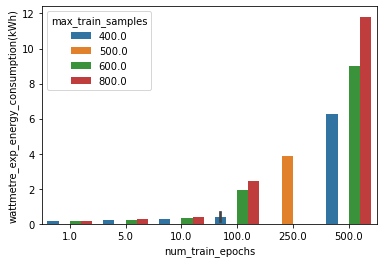

In [14]:
sns.barplot(data=exp_table[exp_table["resolution"]==512], x="num_train_epochs", y="wattmetre_exp_energy_consumption(kWh)", hue="max_train_samples")

## Regression in the number of samples used for the training

In [8]:
# si on suppose que la version du modèle n'impacte pas l'énergie consommée
print("average over model version")
exp_table[(exp_table["resolution"]==256)&(exp_table["num_train_epochs"]==100)].groupby([
       'max_train_samples']).aggregate(['mean', 'var'])[["wattmetre_exp_energy_consumption(kWh)"]]

average over model version


wattmetre_exp_energy_consumption(kWh)              
                                                   mean           var
max_train_samples                                                    
400.0                                          0.497787  5.861345e-05
600.0                                          0.685686  5.439034e-08
800.0                                          0.839842  2.319802e-05

### Compute the preprocessing cost

In [9]:
coefs = []
origins = []
for epochs in [1,10,100,500]:
    print(f"Epochs: {epochs}")
    table = exp_table[(exp_table["resolution"]==256)&(exp_table["num_train_epochs"]==epochs)].groupby([
        'max_train_samples']).aggregate(['mean'])[["wattmetre_exp_energy_consumption(kWh)"]]

    X = np.array([np.array(x) for x in table.index]).reshape(-1, 1)
    y = table.values

    reg = LinearRegression().fit(X, y)
    print(reg.coef_[0][0])
    print(reg.intercept_)
    coefs.append(reg.coef_[0][0])
    origins.append(reg.intercept_[0])

Epochs: 1
1.1441206404017926e-05
[0.15825346]
Epochs: 10
7.289341513143324e-05
[0.16614226]
Epochs: 100
0.0008551392501194675
[0.16135472]
Epochs: 500
0.004022840657422008
[0.39111062]


In [10]:
origin = np.mean(origins)
print(np.round(origin,4))
np.var(origins)

0.2192


0.009857235052269342

### Remove origin and evaluate energy_per_epoch

In [11]:
img_size = 256

In [12]:
exp_table["without_preproc_wattmetre_exp_energy_consumption(kWh)"] = exp_table["wattmetre_exp_energy_consumption(kWh)"] - 0.1619
exp_table["per_epoch_energy_consumption(kWh)"] = exp_table["without_preproc_wattmetre_exp_energy_consumption(kWh)"]/exp_table["num_train_epochs"] 

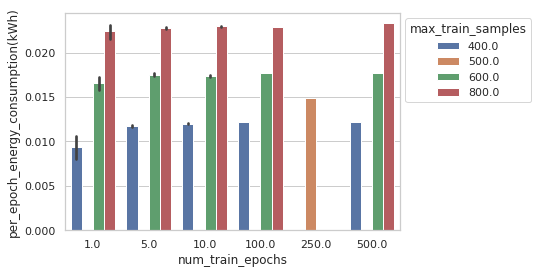

In [21]:
ax = sns.barplot(data=exp_table[(exp_table["resolution"]==512)], #&(exp_table["num_train_epochs"]!=1)], 
            x="num_train_epochs", 
            y="per_epoch_energy_consumption(kWh)", 
            hue="max_train_samples"
            )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [36]:
coefs = []
origins = []
for epochs in [5, 10,100,500]:
    print(f"Epochs: {epochs}")
    table = exp_table[(exp_table["resolution"]==img_size)&(exp_table["num_train_epochs"]==epochs)].groupby([
        'max_train_samples']).aggregate(['mean'])[["per_epoch_energy_consumption(kWh)"]]

    X = np.array([np.array(x) for x in table.index]).reshape(-1, 1)
    y = table.values

    reg = LinearRegression().fit(X, y)
    print(reg.coef_[0][0])
    coefs.append(reg)

Epochs: 5
2.7567320404070543e-05
Epochs: 10
2.7404075600114534e-05
Epochs: 100
2.6789691714623775e-05
Epochs: 500
2.765911550197251e-05


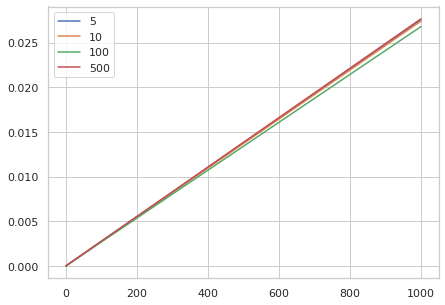

In [38]:
fig, ax = plt.subplots(figsize=(7,5))
index = [0,400,600,800,1000]
index = np.array([np.array(x) for x in index]).reshape(-1, 1)
for epoch_id, epochs in enumerate([5, 10,100,500]):
    prop = coefs[epoch_id].predict(index) - coefs[epoch_id].intercept_
    ax.plot(index, prop, label=epochs)
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[400.]
 [500.]
 [600.]
 [800.]]
[[0.30594647]
 [1.27115543]
 [0.37912479]
 [0.36264838]]
-0.0006606089712289996


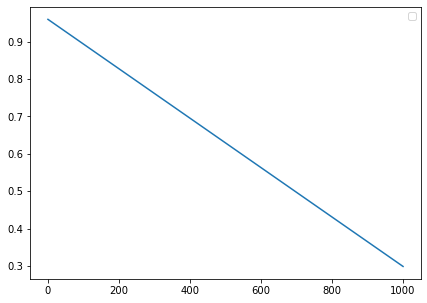

In [16]:
fig, ax = plt.subplots(figsize=(7,5))

table = exp_table[(exp_table["resolution"]==img_size)].groupby([
        'max_train_samples'])[["wattmetre_exp_energy_consumption(kWh)"]]
X = np.array([np.array(x) for x in table.mean().index]).reshape(-1, 1)
y = table.mean().values
print(X)
print(y)
reg = LinearRegression().fit(X, y)
print(reg.coef_[0][0])

index = [0,400,600,800,1000]
index = np.array([np.array(x) for x in index]).reshape(-1, 1)
# y = [x*reg.coef_[0][0] for x in index]
y = reg.predict(index)
ax.plot(index, y)

ax.legend()

In [17]:
print("Equation for image size of 256: energy consumed (kWh) = " + \
    f"{8.55139250119468e-06:e} x number of samples x number of steps")

print("Equation for image size of 512: energy consumed (kWh) = " + \
    f"{2.6789691714623775e-05:e} x number of samples x number of steps")


Equation for image size of 256: energy consumed (kWh) = 8.551393e-06 x number of samples x number of steps
Equation for image size of 512: energy consumed (kWh) = 2.678969e-05 x number of samples x number of steps


## Using only the number of steps

In [18]:
import math
def compute_steps(row):
    update_per_epoch = math.ceil(row["max_train_samples"]/(row["gradient_accumulation_steps"]*row["train_batch_size"]*row["gpu_count"]))
    return row["num_train_epochs"]*update_per_epoch

exp_table["num_steps"] = exp_table.apply(compute_steps, axis=1)

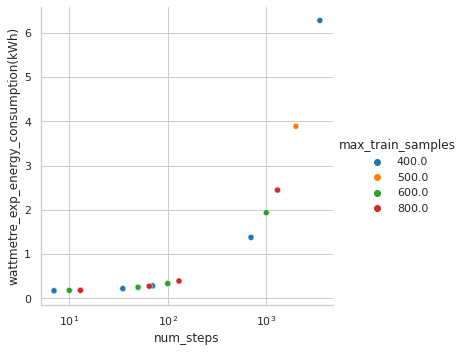

In [33]:

sns.set_theme(style="whitegrid")
sns.color_palette("tab10")

sns.relplot(data=exp_table[(exp_table["resolution"]==512)&(exp_table["num_steps"]<5000)], x="num_steps", y="wattmetre_exp_energy_consumption(kWh)", hue="max_train_samples", palette="tab10")
plt.xscale('log')

0.0017706343087111431
0.16515983863878425


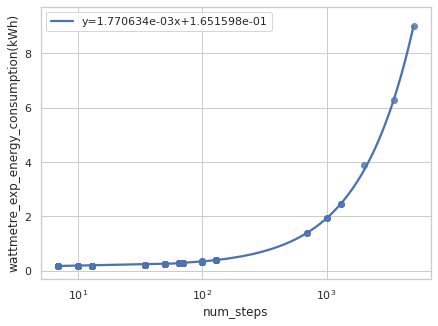

In [32]:
fig, ax = plt.subplots(figsize=(7,5))

img_size = 512

table = exp_table[(exp_table["resolution"]==img_size)&(exp_table["num_steps"]<6000)].groupby([
        'num_steps'])[["wattmetre_exp_energy_consumption(kWh)"]]

X = np.array([np.array(x) for x in table.mean().index]).reshape(-1, 1)
y = table.mean().values

reg = LinearRegression().fit(X, y)

print(reg.coef_[0][0])
print(reg.intercept_[0])

#  lmplot
ax = sns.regplot(data=exp_table[(exp_table["resolution"]==img_size)&(exp_table["num_steps"]<6000)],
            x="num_steps",
            y="wattmetre_exp_energy_consumption(kWh)",
            # hue="resolution",
            line_kws={'label':"y={0:e}x+{1:e}".format(reg.coef_[0][0],reg.intercept_[0])})
ax.legend()
plt.xscale('log')
